# V6-NN Enhanced: Heart Sound Classification using a Neural Network

이 노트북은 **전처리된 웨이브릿 특성**을 사용하여 심장 소리를 분류하는 **향상된 신경망(Enhanced Multi-Layer Perceptron)**을 훈련합니다.


In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# --- 1. Configuration ---
# V6 웨이브릿 데이터 경로
WAVELET_DATA_DIR = '/workspace/wavelet_v6/'

In [10]:
# --- 2. Data Loading ---
X = []
y = []

print(f"Loading V6 wavelet data from {WAVELET_DATA_DIR}...")

# Check if the directory exists
if not os.path.isdir(WAVELET_DATA_DIR):
    print(f"Error: Directory not found at {os.path.abspath(WAVELET_DATA_DIR)}")
    print("Please run the preprocessing script first: python preprocess_wavelet.py")
else:
    files = os.listdir(WAVELET_DATA_DIR)
    npz_files = [f for f in files if f.endswith('.npz')]
    
    if not npz_files:
        print(f"No .npz files found in {WAVELET_DATA_DIR}. Please run preprocessing first.")
    else:
        print(f"Found {len(npz_files)} .npz files")
        
        # Load all wavelet feature files
        for file_name in npz_files:
            path = os.path.join(WAVELET_DATA_DIR, file_name)
            try:
                data = np.load(path)
                
                # Load features and labels using the new format
                if 'features' in data and 'label' in data:
                    X.append(data['features'])
                    y.append(data['label'])
                else:
                    print(f"Warning: Expected keys 'features' and 'label' not found in {file_name}")
                    
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
        
        if X:
            # Convert to numpy arrays
            X = np.array(X)
            y = np.array(y)
            
            print(f"\n=== V4 Data Loading Complete ===")
            print(f"Successfully loaded {len(X)} samples.")
            print(f"Feature matrix shape: {X.shape}")
            print(f"Label distribution: Normal (0): {np.sum(y == 0)}, Abnormal (1): {np.sum(y == 1)}")
            print(f"Class balance: {np.sum(y == 0)/(len(y))*100:.1f}% normal, {np.sum(y == 1)/(len(y))*100:.1f}% abnormal")
        else:
            print("No valid data could be loaded.")

Loading V6 wavelet data from /workspace/wavelet_v6/...
Found 3240 .npz files

=== V4 Data Loading Complete ===
Successfully loaded 3240 samples.
Feature matrix shape: (3240, 1024)
Label distribution: Normal (0): 2575, Abnormal (1): 665
Class balance: 79.5% normal, 20.5% abnormal


In [11]:
# --- 3. Data Preparation ---
if len(X) > 0:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f'=== V4 Data Preparation Complete ===')
    print(f'Training set shape: {X_train_scaled.shape}')
    print(f'Test set shape: {X_test_scaled.shape}')
    print(f'Training label distribution: Normal: {np.sum(y_train == 0)}, Abnormal: {np.sum(y_train == 1)}')
    print(f'Test label distribution: Normal: {np.sum(y_test == 0)}, Abnormal: {np.sum(y_test == 1)}')
else:
    print("Skipping model training as no data was loaded.")

=== V4 Data Preparation Complete ===
Training set shape: (2592, 1024)
Test set shape: (648, 1024)
Training label distribution: Normal: 2060, Abnormal: 532
Test label distribution: Normal: 515, Abnormal: 133


In [12]:
# --- 3.5. Data Augmentation (Reduced) ---
def augment_data(X, y, augmentation_factor=0.5):
    """
    웨이브릿 특성 데이터에 가벼운 노이즈 추가를 통한 제한적 데이터 증강
    """
    augmented_X = []
    augmented_y = []
    
    # 원본 데이터 추가
    augmented_X.extend(X)
    augmented_y.extend(y)
    
    print(f"Applying light data augmentation (factor: {augmentation_factor})...")
    
    # 더 적은 증강으로 과적합 방지
    num_augment = int(len(X) * augmentation_factor)
    indices = np.random.choice(len(X), num_augment, replace=False)
    
    for i in indices:
        sample, label = X[i], y[i]
        
        # 1. 매우 작은 가우시안 노이즈만 추가
        noise = np.random.normal(0, 0.005, sample.shape)  # 노이즈 크기 감소
        augmented_sample = sample + noise
        
        augmented_X.append(augmented_sample)
        augmented_y.append(label)
    
    return np.array(augmented_X), np.array(augmented_y)

if len(X) > 0:
    # 제한적 데이터 증강 적용
    X_augmented, y_augmented = augment_data(X, y, augmentation_factor=0.3)
    
    print(f"Original data size: {len(X)}")
    print(f"Augmented data size: {len(X_augmented)}")
    print(f"Augmentation ratio: {len(X_augmented)/len(X):.1f}x")
    
    # 증강된 데이터로 업데이트
    X = X_augmented
    y = y_augmented

Applying light data augmentation (factor: 0.3)...
Original data size: 3240
Augmented data size: 4212
Augmentation ratio: 1.3x


In [13]:
# --- 4. Model Definition (Simplified for Better Generalization) ---
if len(X) > 0:
    model = Sequential([
        # 더 작은 첫 번째 레이어
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.6),  # 더 강한 드롭아웃
        
        # 중간 레이어
        Dense(64, activation='relu'),
        Dropout(0.5),
        
        # 마지막 은닉층
        Dense(32, activation='relu'),
        Dropout(0.4),
        
        # 출력층
        Dense(1, activation='sigmoid')
    ])

    print("=== V6 Balanced Model Architecture ===")
    model.summary()

=== V6 Balanced Model Architecture ===


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,569 (553.00 KB)

 Trainable params: 141,569 (553.00 KB)

 Non-trainable params: 0 (0.00 B)

=== Starting V6 Balanced Model Training (No Early Stopping) ===
Initial learning rate: 0.0005000000237487257
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6726 - loss: 0.7518 - val_accuracy: 0.7932 - val_loss: 0.5298 - learning_rate: 5.0000e-04
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7416 - loss: 0.6654 - val_accuracy: 0.7932 - val_loss: 0.5432 - learning_rate: 5.0000e-04
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7176 - loss: 0.6883 - val_accuracy: 0.7948 - val_loss: 0.5397 - learning_rate: 5.0000e-04
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7557 - loss: 0.6018 - val_accuracy: 0.7948 - val_loss: 0.5423 - learning_rate: 5.0000e-04
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7655 - loss: 0.5815 - val_accuracy: 0.7948 - val_loss: 0.5359 - learning_rate: 5.0000e-04
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7731 - loss: 0.5712 - val_accuracy: 0.7948 - val_lo

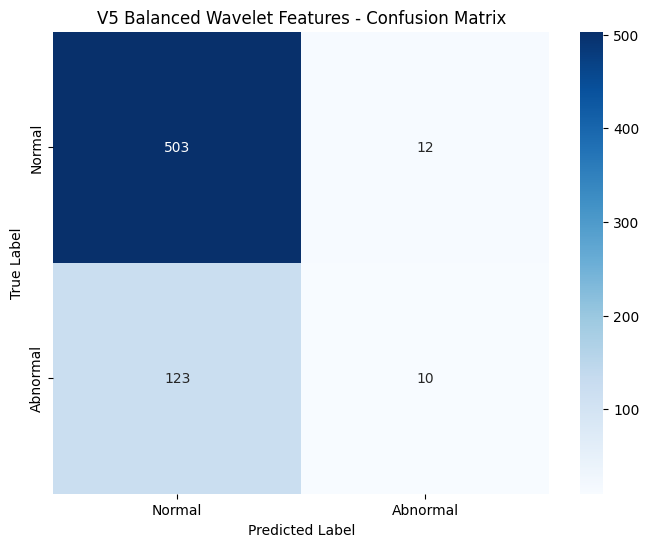

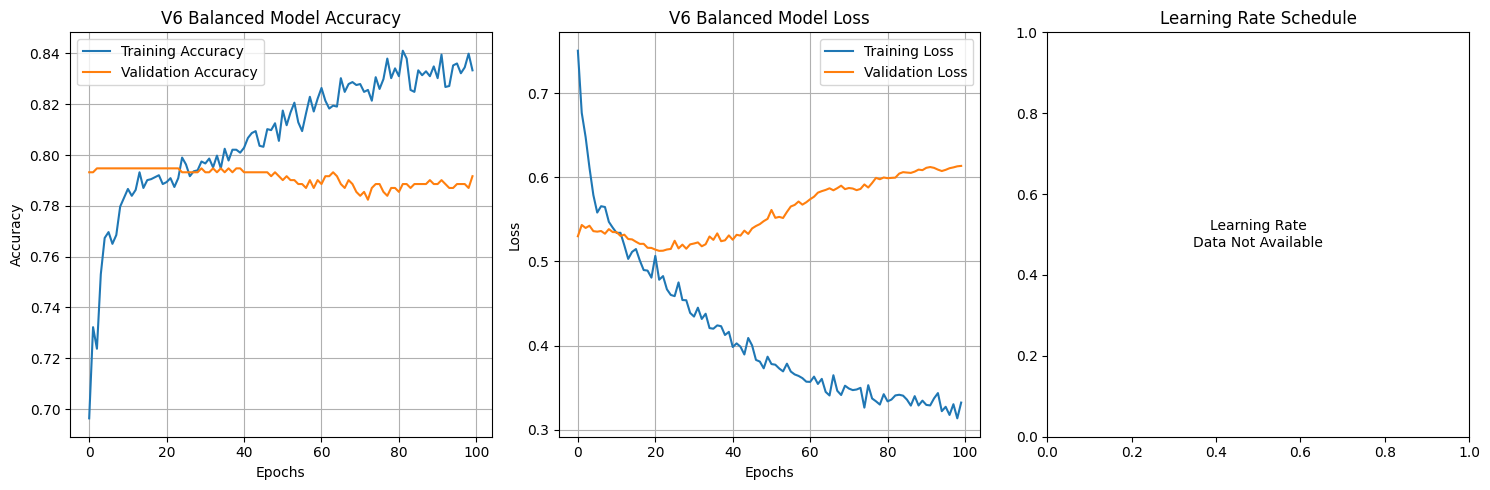


=== V6 Balanced Training Summary ===
Training completed at epoch: 100
Best validation accuracy: 0.7948
Final test accuracy: 0.7917
Final learning rate: 1.41e-05

=== Overfitting Analysis ===
Final Training Accuracy: 0.8333
Final Validation Accuracy: 0.7917
Training-Validation Gap: 0.0417
✅ Good generalization

=== Additional Performance Metrics ===
Precision: 0.4545
Recall: 0.0752
F1-Score: 0.1290


In [14]:
# --- 5. Model Training & Evaluation (Balanced Approach) ---
if len(X) > 0:
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ReduceLROnPlateau
    
    # 더 보수적인 옵티마이저 설정
    optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)  # 낮은 학습률
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 학습률 감소 스케줄러만 사용
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,              # 더 점진적인 감소
        patience=8,              # 더 빠른 반응
        min_lr=1e-6,
        verbose=1
    )

    print("=== Starting V6 Balanced Model Training (No Early Stopping) ===")
    print(f"Initial learning rate: {optimizer.learning_rate.numpy()}")
    
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=100,              # 모든 에포크 완료
        batch_size=64,           # 더 큰 배치 크기로 안정성 향상
        validation_data=(X_test_scaled, y_test),
        callbacks=[reduce_lr],   # early_stopping 제거
        verbose=1
    )

    print("\n=== V6 Balanced Final Model Evaluation ===")
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Loss: {loss:.4f}")

    # Make predictions for detailed analysis
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Classification report
    print("\n=== Detailed Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Abnormal'], 
                yticklabels=['Normal', 'Abnormal'])
    plt.title('V5 Balanced Wavelet Features - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- Plotting Training History ---
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('V6 Balanced Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('V6 Balanced Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Learning Rate plot (if available)
    plt.subplot(1, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nData Not Available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== V6 Balanced Training Summary ===")
    print(f"Training completed at epoch: {len(history.history['loss'])}")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Final test accuracy: {accuracy:.4f}")
    print(f"Final learning rate: {optimizer.learning_rate.numpy():.2e}")
    
    # Training vs Validation gap 분석
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    
    print(f"\n=== Overfitting Analysis ===")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training-Validation Gap: {gap:.4f}")
    if gap > 0.1:
        print("⚠️  High overfitting detected!")
    elif gap > 0.05:
        print("⚠️  Moderate overfitting detected")
    else:
        print("✅ Good generalization")
    
    # 추가 성능 지표
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n=== Additional Performance Metrics ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")